In [1]:
import os
import jax
import numpy as np
jax.devices()

[CpuDevice(id=0)]

In [2]:
os.chdir("../../..")
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga
from scripts.Sim_Visializations import *

## Получаем данные

In [3]:
res = ga.load_jax_context("Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz")

Загрузка контекста из: Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [4]:
stom = jnp.array(res['stom'])

In [5]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

In [6]:
stom

Array([[10191936,      132],
       [11531426,     1144],
       [12132809,     1481],
       [12927058,     1828],
       [17855652,     5258],
       [ 1805496,     5361],
       [19255911,     5940],
       [ 2662497,     9022],
       [ 4505350,    10191],
       [ 4982132,    10926],
       [ 5018684,    11025],
       [ 7056349,    11455],
       [ 7810915,    11843],
       [ 7843014,    12032],
       [ 8108327,    12470],
       [ 8250193,    12546],
       [ 8824003,    13248],
       [ 8939282,    13386],
       [ 8981142,    13448],
       [ 9011915,    13726]], dtype=int32)

## Определяем структуру симуляции

In [7]:
a, b = '7055857', '1805418'
ind_to_stim = stom[7][1]
ind_to_stim1 = stom[8][1]

def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T

    D = 1
    Ra = 100
    Cm = constants['C']
    sync_coof = 4*Ra/(D*Cm)

    HH = get_HH_pipeline_SGGE(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V', scaling = sync_coof) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_pipeline(pre_syn, post_syn, **constants)

    cable_integrator = get_backward_euler_linear_step(cable, 'V', dt)

    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы

        #s, ds = cable(s, ds) # соединяет сегменты

        #ds['V'] += ds['V'].at[ind_to_stim1].add(0.7)
        ds['V'] = ds['V'].at[ind_to_stim1].add(70*(s['time'] > 40.0)*(s['time'] < 90.0))
        ds['V'] = ds['V'].at[ind_to_stim].add(70*(s['time'] > 40.0)*(s['time'] < 90.0))
        return s, ds

    soft_integrator = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    #integrate = get_euler_step(state_transformed, dt)
    @jax.jit
    def my_pipeline(state):
        s = soft_integrator(state)
        s = cable_integrator(s)
        return s
    return my_pipeline

### Начальные значения и константы


In [8]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-77.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.05529518,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.32336363,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.58303326,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.0,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.0,
    'synaptic_weights':100.0,
    'G_max':1.0
}

scale = 1000
new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0, #mV
    "EK": -77.0, #mV
    "EL": -54, #mV
    "gNa": jnp.array(res['gnabar_hh'])*scale,# mS/cm^2
    "gK": jnp.array(res['gkbar_hh'])*scale,  # mS/cm^2
    "gL": jnp.array(res['gl_hh'])*scale,     # mS/cm^2
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

SGGE_HH_channel_params = {
        "gNa": 0.12*1000,
        "gK": 0.036*1000,
        "gL": 0.0003*1000,
        "ENa": 50.0,
        "EK": -77.0,
        "EL": -54.3,
    }

CCC = consts | SGGE_HH_channel_params

In [9]:
res['gnabar_hh']

array([0.01690865, 0.01690865, 0.01690865, ..., 0.04581579, 0.01615279,
       0.0893713 ], shape=(14409,))

In [10]:
res['gnabar_hh'].shape

(14409,)

In [11]:
np.mean(np.array(res['gnabar_hh'])*scale)

np.float64(36.200451469839024)

In [12]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [13]:
my_pipeline = get_my_pipeline(new_consts, 0.1)

In [14]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get(), state['m'].at[stom[:, 1]].get(), state['n'].at[stom[:, 1]].get(), state['h'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 10, output_transform)
H = jsim.run(100)

In [15]:
np.max(H[1])

Array(31.145948, dtype=float32)

## Построение графиков

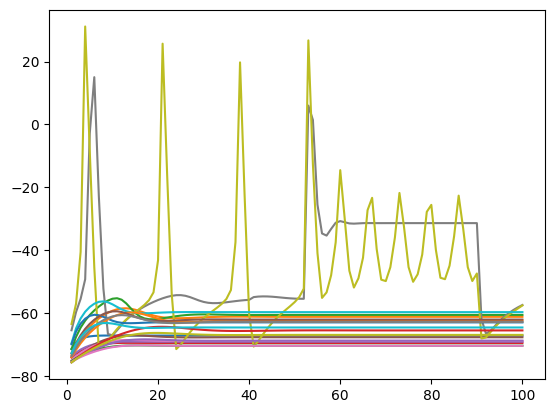

In [16]:
t, v, m, n, h = H
plt.plot(t, v)
plt.show()

In [17]:
Vd = dict()
for i, vs in enumerate(v.T):
    Vd[int(stom[i][0])] = vs

plot_results(t, Vd, (40, 90), interactive=True)

- нет четкого соответствия реализации в Neuron
- alpha синапсы вместо exp
- ~~не тот маштаб времени **<- вот основная проблема** (скорее всего вызванно тем, что измеряем в разных еденицах, мне на 1000 приходится умножать)~~ <- у меня в микросименсах, а там в сименсах
- ~~не те потенциалы покоя, в общем схожи, нижняя граница совпадает, но не верхняя у меня -55. (точно не из за alpha синапсов)~~
- не совпадают стимулы, я подаю ток в 70 мА и ничо не получаю, а должно получатся при 0.7 (скорее всего как то связано с еденицами измерения)
- симуляция взрывается даже при небольшом повышении коофициента перед cable. А он в теории должен быть очень большим